# Capstone Project :: EYE FOR THE BLIND
Abhishek Jain 


**Problem statement:** In this capstone project, we need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

#### Approach:

- Data Understansing <br>
- Data Pre Processing <br>
- Train Test Split <br>
- Model Building : Encoder, Decoder, Attention Models <br>
- Model Evaluation <br>

In [1]:
# Installing the gtts library for TTS conversion

!pip install gtts

In [2]:
#Import all the required libraries
import pandas as pd
import glob
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import numpy as np

# Libraries for Images
from IPython.display import Image as pyImg
from PIL import Image


# Libraries for Audio
from gtts import gTTS
from IPython.display import Audio


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



### Let's Explore the dataset directory structure

Data is present in the data folder at below path.

In [3]:
# Mounting the google drive for dataset import

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!ls "/content/drive/My Drive/archive (1)"

20180225_174323.jpg  capstone  captions.txt  checkpoint  Images  s.wav


Initialize global variables pointing to the images folder and base folder containing the caption file.

In [5]:

imagesBasePath = "/content/drive/My Drive/archive (1)/Images"
basePath = "/content/drive/My Drive/archive (1)"

Lets check the format of the images present in the images folder

In [6]:
all_imgs = glob.glob(imagesBasePath + '/*',recursive=True)
set([ img_name.split(".")[1] for img_name in all_imgs])

{'jpg'}

All the images are of jpg format.
Lets count the total number of images.

In [7]:
all_imgs = glob.glob(imagesBasePath + '/*.jpg',recursive=True)
print("Total Images present in The Dataset: {}".format(len(all_imgs)))

Total Images present in The Dataset: 8091


In [8]:
# Checking Image Paths

df_image_paths = pd.DataFrame([img.split("/")[-1] for img in all_imgs],columns=['image'])
df_image_paths

image
0      395461421_c586b136de.jpg
1     3765374230_cb1bbee0cb.jpg
2      392467282_00bb22e201.jpg
3     3756150099_50882fc029.jpg
4      392976422_c8d0514bc3.jpg
...                         ...
8086  1115565519_d976d4b1f1.jpg
8087   111537222_07e56d5a30.jpg
8088  1124448967_2221af8dc5.jpg
8089   108898978_7713be88fc.jpg
8090  1077546505_a4f6c4daa9.jpg

[8091 rows x 1 columns]

### Visualize some images and captions

Visualizing some random images

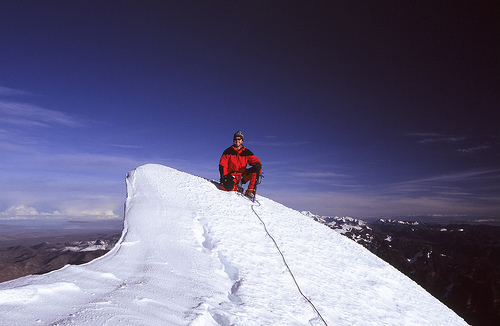

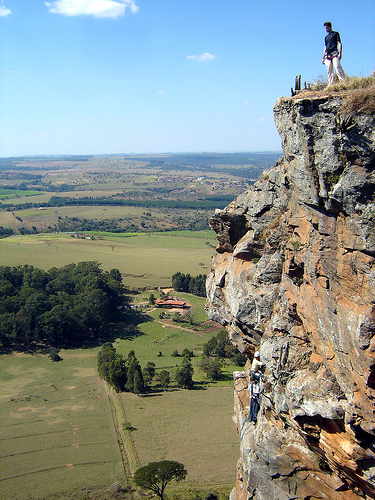

In [9]:
from IPython.display import Image as pyImg
a = pyImg(filename=f'{imagesBasePath}/55473406_1d2271c1f2.jpg')
b = pyImg(filename=f'{imagesBasePath}/143684568_3c59299bae.jpg')

display(a,b)

Reading Captions data as pandas dataframe

In [10]:
caption_file = f"{basePath}/captions.txt"


In [11]:
df_captions = pd.read_csv(caption_file,sep=",")
df_captions.head()

image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...

Lets check if all images have exactly 5 captions.

In [12]:
df_captions_per_image = df_captions.groupby('image').count().reset_index()
df_captions_per_image[df_captions_per_image['caption'] != 5]


Empty DataFrame
Columns: [image, caption]
Index: []

As seen above the dataframe is empty meaning there is no image having more or less than 5 captions

We can conclude we have we have 5 captions for each image mentioned in the caption file.<br>Lets check if we have captions for all images present in the dataset.

In [13]:
pd.merge(df_image_paths, df_captions_per_image, how= "outer", on="image")

# here we can see the count is 8091.


image  caption
0      395461421_c586b136de.jpg        5
1     3765374230_cb1bbee0cb.jpg        5
2      392467282_00bb22e201.jpg        5
3     3756150099_50882fc029.jpg        5
4      392976422_c8d0514bc3.jpg        5
...                         ...      ...
8086  1115565519_d976d4b1f1.jpg        5
8087   111537222_07e56d5a30.jpg        5
8088  1124448967_2221af8dc5.jpg        5
8089   108898978_7713be88fc.jpg        5
8090  1077546505_a4f6c4daa9.jpg        5

[8091 rows x 2 columns]

Hence we conclude all images have caption details given to us.

In [14]:
# Read caption file as string.
with open(caption_file,'r') as c:
    caption_data = c.read()
    c.close()

caption_data[:1000].splitlines()

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow wi

### Create Consolidated Dataframe
Creating below dataframe to summarize the image, path & captions details.

Since each image has 5 caption total data size is 8091*5 = 40455

create separate list of image paths, tagged annotations/captions

In [15]:
l = [[row.split(',')[0],f"{imagesBasePath}/{row.split(',')[0]}",row.split(',')[1]] for row in caption_data.splitlines()[1:]]

df = pd.DataFrame(l,columns =['ID','Path', 'Captions'])
      
all_img_id = list(df['ID'])
all_img_vector = list(df['Path'])
annotations = list(df['Captions'])

df.head()

ID  ...                                           Captions
0  1000268201_693b08cb0e.jpg  ...  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg  ...              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg  ...   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  ...  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  ...  A little girl in a pink dress going into a woo...

[5 rows x 3 columns]

In [16]:
#Creating a list which contains all the captions
annotations= list(df['Captions'])

#adding <start> & <end> token to all those captions
taggedAnnotations = [f'<start> {item} <end>'for item in annotations]

#Creating a list which contains all the path to the images
all_img_path= list(df['Path'])

print("Total captions in the dataset: "+ str(len(taggedAnnotations)))
print("Total images in the dataset: " + str(len(all_img_path)))

Total captions in the dataset: 40455
Total images in the dataset: 40455


In [17]:
taggedAnnotations[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

### Creating Vocubulary

In [18]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for caption in annotations for word in caption.split()]

print(f"Vocabulary Size : {len(set(vocabulary))}")
word_count=Counter(vocabulary)
word_count

Vocabulary Size : 9536


Counter({'A': 21480,
         'child': 1449,
         'in': 18170,
         'a': 38716,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1870,
         'entry': 1,
         'way': 48,
         '.': 34205,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         'spots': 28,
         'staring'

### Visualise the top 30 occuring words in the captions

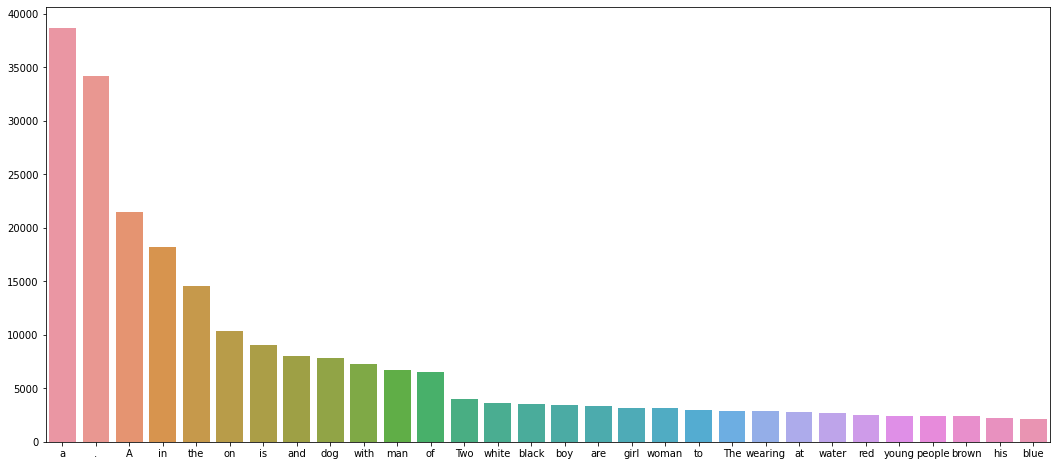

In [19]:
most_common_words = word_count.most_common(30)
most_common_words = pd.DataFrame(most_common_words)
#write your code here
most_common_words

plt.figure(figsize=(18,8))
sns.barplot(x=list(most_common_words[0]),y=list(most_common_words[1]))

From above it is depicted that the most common word with 'a/A',   '.', 'in', 'the' and 'on' being the most frequent ones in captions

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions for example :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

Here we will take help if keras text preprocessing to perform following steps:-
- Tokenize all the words present in the vocabulary.
- Take only the top 5000 most frequent words.
- filter out characters like '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
- use '< unk >' to replace words which are out of vocabulary while text_to_sequences call



In [20]:
# Tokensizing

maxWordCount = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=maxWordCount+1,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(taggedAnnotations)
tokenized_sequences = tokenizer.texts_to_sequences(taggedAnnotations)


We will now introduce a new word <pad> which will be used for padding the short sentences to match their length with the final required length.

We will assign its token value as 0

In [21]:

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

Lets take a look at both of the word to index and index to work mappings

In [22]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'dog': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'two': 14,
 'white': 15,
 'black': 16,
 'boy': 17,
 'are': 18,
 'woman': 19,
 'girl': 20,
 'to': 21,
 'wearing': 22,
 'people': 23,
 'at': 24,
 'water': 25,
 'young': 26,
 'red': 27,
 'brown': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'dogs': 32,
 'running': 33,
 'through': 34,
 'playing': 35,
 'shirt': 36,
 'while': 37,
 'down': 38,
 'little': 39,
 'standing': 40,
 'ball': 41,
 'grass': 42,
 'person': 43,
 'child': 44,
 'snow': 45,
 'jumping': 46,
 'over': 47,
 'three': 48,
 'front': 49,
 'sitting': 50,
 'small': 51,
 'up': 52,
 'field': 53,
 'holding': 54,
 'large': 55,
 'group': 56,
 'by': 57,
 'green': 58,
 'yellow': 59,
 'children': 60,
 'walking': 61,
 'men': 62,
 'her': 63,
 'into': 64,
 'beach': 65,
 'air': 66,
 'near': 67,
 'jumps': 68,
 'mouth': 69,
 'street': 70,
 'runs': 71,
 'for': 72,
 'another': 73,
 'riding': 74,
 'from': 

In [23]:
 tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'people',
 24: 'at',
 25: 'water',
 26: 'young',
 27: 'red',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'shirt',
 37: 'while',
 38: 'down',
 39: 'little',
 40: 'standing',
 41: 'ball',
 42: 'grass',
 43: 'person',
 44: 'child',
 45: 'snow',
 46: 'jumping',
 47: 'over',
 48: 'three',
 49: 'front',
 50: 'sitting',
 51: 'small',
 52: 'up',
 53: 'field',
 54: 'holding',
 55: 'large',
 56: 'group',
 57: 'by',
 58: 'green',
 59: 'yellow',
 60: 'children',
 61: 'walking',
 62: 'men',
 63: 'her',
 64: 'into',
 65: 'beach',
 66: 'air',
 67: 'near',
 68: 'jumps',
 69: 'mouth',
 70: 'street',
 71: 'runs',
 72: 'for',
 73: 'another',
 74: 'riding',
 75: 'fro

### Visualise the top 30 occuring words after Preprocessing

word  count
1          a  61436
0    <start>  40455
15     <end>  40455
3         in  18193
23       the  17677
39        on  10369
6         is   9069
29       and   8066
28       dog   7958
36      with   7308
76       man   7172
10        of   6504
47       two   5550
41     white   3728
27     black   3641
144      boy   3534
31       are   3365
233    woman   3320
16      girl   3284
24        to   3008
102  wearing   2917
195   people   2837
45        at   2820
139    water   2683
74     young   2610
111      red   2571
42     brown   2484
12        an   2358
80       his   2255
160     blue   2136

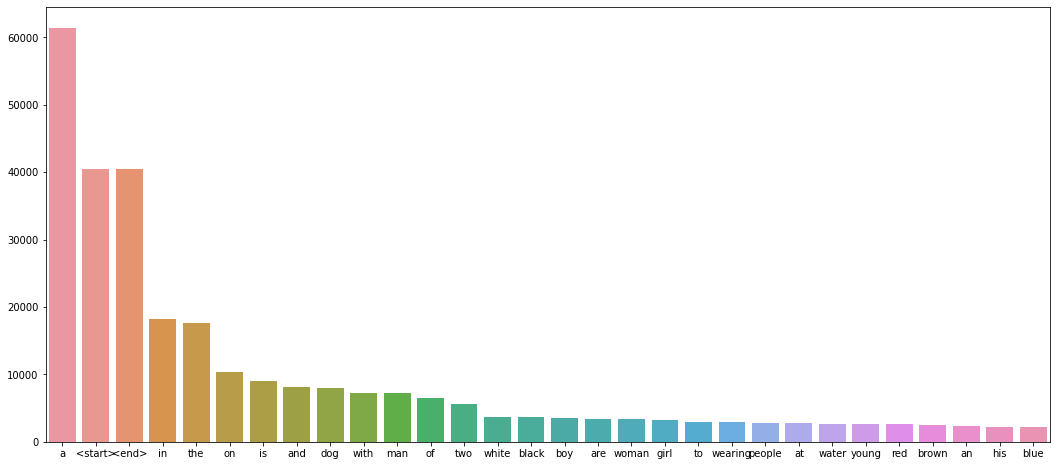

In [24]:
dfProcessedVocab = pd.DataFrame(list(zip(list(tokenizer.word_counts.keys()),list(tokenizer.word_counts.values()))), columns = ['word','count'])

dfProcessedVocab = dfProcessedVocab.sort_values(by='count', ascending=False, na_position='first').iloc[0:30]
display(dfProcessedVocab)

plt.figure(figsize=(18,8))
sns.barplot(x=list(dfProcessedVocab['word']),y=list(dfProcessedVocab['count']))

Here we can clearly see the punctuations have been removed from the vocabulary.

Two new words < start > and < end > are now part of the top 30 list as these are present now in all the captions.

Now lets add padding to match the length of each caption.

In [25]:
# Pad each vector to the max_length of the captions accross the dataset.

max_length = max(len(seq) for seq in tokenized_sequences)
print(f"Max length of a caption",max_length)
caption_vector= tf.keras.preprocessing.sequence.pad_sequences(tokenized_sequences, padding="post", maxlen= max_length)

print("The shape of Caption vector is :" + str(caption_vector.shape))

Max length of a caption 35
The shape of Caption vector is :(40455, 35)


In [26]:
caption_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 39, ...,  0,  0,  0],
       ...,
       [ 3,  2, 43, ...,  0,  0,  0],
       [ 3,  2, 83, ...,  0,  0,  0],
       [ 3,  2, 83, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


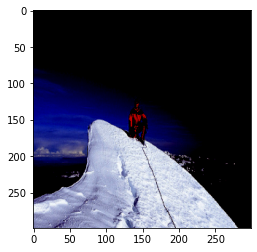

In [83]:
#write your code here 

# Creating a function to return images & their path
def load_image(img_path):
    # Read Image File
    imgObject = tf.io.read_file(img_path)
    imgObject = tf.image.decode_jpeg(imgObject, channels=3)
    
    #Resize Image
    imgObject = tf.image.resize(imgObject, (299, 299))
    imgObject = tf.keras.applications.inception_v3.preprocess_input(imgObject)
    return imgObject, img_path

img1,img1_path = load_image(f"{imagesBasePath}/55473406_1d2271c1f2.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)



For normalizing the images within the range of -1 to 1, we have used above the 
preprocess function of the inception_v3 model class in keras as it normalizes the data in this required range.

### Creating Tensor Flow Dataset containing path of the images.

We creating this we need to define the batch size to be used as the tf dataset is a tensor with has one dimension for the number of batches.


In [28]:
#write your code here to create the dataset consisting of image paths

batchSize = 32
all_images_paths = sorted(set(all_img_vector))

#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

image_data_set = tf.data.Dataset.from_tensor_slices(all_images_paths)
image_data_set = image_data_set.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batchSize)

In [29]:
for i in image_data_set:
  print(i)
  break

(<tf.Tensor: shape=(32, 299, 299, 3), dtype=float32, numpy=
array([[[[-5.4579198e-01, -5.1085913e-01, -3.7435186e-01],
         [-1.4921635e-01, -1.9675493e-04, -3.1106710e-02],
         [-9.7177267e-02,  4.6858430e-02,  4.3021560e-02],
         ...,
         [-9.7224247e-01, -9.6819955e-01, -9.8191810e-01],
         [-9.6078575e-01, -9.4020623e-01, -9.7377020e-01],
         [-9.6212077e-01, -9.3846858e-01, -9.8195148e-01]],

        [[-5.7653260e-01, -5.3617233e-01, -4.2858374e-01],
         [-1.4806336e-01,  5.8089495e-03, -5.5708170e-02],
         [-7.8158259e-02,  6.0893416e-02,  7.8846335e-02],
         ...,
         [-9.6420521e-01, -9.5636207e-01, -9.8523390e-01],
         [-9.3927324e-01, -9.2645574e-01, -9.5595336e-01],
         [-9.9189347e-01, -9.6899247e-01, -9.7989315e-01]],

        [[-5.9273523e-01, -5.6866682e-01, -4.3528354e-01],
         [-1.3315433e-01,  5.4714680e-03, -1.3691187e-02],
         [-8.0161095e-02,  5.6944609e-02,  1.0495746e-01],
         ...,
         

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [30]:
# write your code to extract features from each image in the dataset

# Here we have used default value 'imagenet' for the weights parameter whichs help in using the pretrained weights of the image net model.
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
# -1 will help in getting the output of the last layer
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [31]:
new_input, hidden_layer

(<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'mixed10')>)

Above confirm that the output of the last layer has 2048 dimensions equal to the number of neuron units this layer.

### Model Summary

In [32]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [33]:
for image, path in image_data_set:
    print(f"Image Dataset Shape {image.shape}")
    batch_features = image_features_extract_model(image)
    print(f"Batch Feature Dataset Shape Original {batch_features.shape}")
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    print(f"Batch Feature Reshaped {batch_features.shape}")
    for batch_f, p in zip(batch_features, path):
        print(f"Image Feature Shape {batch_f.shape}")
        break
    break

Image Dataset Shape (32, 299, 299, 3)
Batch Feature Dataset Shape Original (32, 8, 8, 2048)
Batch Feature Reshaped (32, 64, 2048)
Image Feature Shape (64, 2048)


Above cell confirms correct shape of the each componment before creating the feature map

In [34]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

# Additionally we are going to store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model 
feature_dict = {}

for image, path in tqdm(image_data_set):
    # Extracting features 
    batch_features = image_features_extract_model(image)
    # Reshaping features from 32*8*8*2048 to 32*64*2048
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    # Populate the feature dictionary    
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [16:42<00:00,  3.96s/it]


In [35]:
feature_dict

{'/content/drive/My Drive/archive (1)/Images/1000268201_693b08cb0e.jpg': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.1698735 ],
        [0.        , 0.        , 1.0105954 , ..., 0.        , 0.        ,
         0.06111975],
        ...,
        [0.        , 0.        , 2.038048  , ..., 1.2029716 , 0.        ,
         1.9924188 ],
        [0.        , 0.        , 0.9046925 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.2527338 , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '/content/drive/My Drive/archive (1)/Images/1001773457_577c3a7d70.jpg': array([[0.        , 0.6636934 , 0.46285915, ..., 0.        , 0.        ,
         3.3322668 ],
        [0.        , 1.2268212 , 0.        , ..., 0.        , 0.25389993,
         3.329542  ],
        [1.2881913 , 1.5195441 , 0.        , ..., 0.467784

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [36]:
#write your code here
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [37]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [38]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.


def map_function(image_name, caption):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [39]:
type(feature_dict)

dict

In [40]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000


In [41]:
import tensorflow_datasets as tfds

In [42]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [43]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

Checking the final train and test datasets

In [44]:
for i in train_dataset:
  print(i)
  break

(<tf.Tensor: shape=(32, 64, 2048), dtype=float32, numpy=
array([[[0.        , 0.        , 1.340731  , ..., 0.        ,
         0.36052874, 0.        ],
        [0.        , 0.        , 0.8850102 , ..., 0.        ,
         0.20005365, 0.        ],
        [0.        , 0.        , 0.551257  , ..., 0.        ,
         0.4496726 , 0.35647252],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.40523562, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.05907113, 0.        , 0.        , ..., 0.18100221,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.6317176 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.59578574, ..., 0.90315163,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0

In [45]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [47]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE


### Encoder

In [48]:
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model

In [49]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #self.dense = #build your Dense layer with relu activation
        self.fc = layers.Dense(embed_dim)
        #self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        #features =  # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [50]:
encoder=Encoder(embedding_dim)

### Attention model

In [51]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights


### Decoder

In [52]:
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

In [53]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        #self.embed = layers.Embedding(vocab_size, embed_dim)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        #embed = self.dropout(self.embed(x)) #shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        mask = self.embed.compute_mask(x)
        
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights#,mask #f"{embed.shape}", embed
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [54]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [55]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

print(hidden.shape)
predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print(hidden.shape)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, 1)

(32, 512)
(32, 512)
Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


In [56]:
# Defining the parameters for the model

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [57]:
# Defining the loss function

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [58]:
checkpoint_path = f"{basePath}/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [59]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [60]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.init_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
        
  avg_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, avg_loss


* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [61]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        predicted_id = tf.argmax(predictions, axis = 1)
        
        loss += loss_function(target[:, i], predictions)
        
        dec_input = tf.expand_dims(predicted_id, 1)
        
    avg_loss = (loss / int(target.shape[1]))
    
    return loss, avg_loss

In [1]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        
        total_loss += t_loss
        
        avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [63]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        print(batch, sep=' ', end=' ', flush=True)
        #print(img_tensor.shape)

        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('\nFor epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

  7%|▋         | 1/15 [06:59<1:37:59, 419.97s/it]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

 13%|█▎        | 2/15 [12:12<1:23:59, 387.67s/it]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

 20%|██        | 3/15 [17:23<1:12:55, 364.60s/it]


For epoch: 3, the train loss is 0.917, & test loss is 2.036
Time taken for 1 epoch 310.76904034614563 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

 27%|██▋       | 4/15 [22:34<1:03:53, 348.52s/it]


For epoch: 4, the train loss is 0.850, & test loss is 2.092
Time taken for 1 epoch 310.994259595871 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 

 33%|███▎      | 5/15 [27:45<56:12, 337.28s/it]  


For epoch: 5, the train loss is 0.794, & test loss is 2.090
Time taken for 1 epoch 311.0651288032532 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250

 40%|████      | 6/15 [32:57<49:27, 329.77s/it]


For epoch: 6, the train loss is 0.744, & test loss is 2.128
Time taken for 1 epoch 312.24212527275085 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

 47%|████▋     | 7/15 [38:14<43:26, 325.86s/it]


For epoch: 7, the train loss is 0.697, & test loss is 2.216
Time taken for 1 epoch 316.72692799568176 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

 53%|█████▎    | 8/15 [43:25<37:31, 321.67s/it]


For epoch: 8, the train loss is 0.655, & test loss is 2.254
Time taken for 1 epoch 311.89728116989136 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

 60%|██████    | 9/15 [48:36<31:50, 318.40s/it]


For epoch: 9, the train loss is 0.615, & test loss is 2.319
Time taken for 1 epoch 310.7508900165558 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250

 67%|██████▋   | 10/15 [53:46<26:19, 315.92s/it]


For epoch: 10, the train loss is 0.579, & test loss is 2.422
Time taken for 1 epoch 310.1513421535492 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

 73%|███████▎  | 11/15 [58:59<20:59, 314.85s/it]


For epoch: 11, the train loss is 0.545, & test loss is 2.517
Time taken for 1 epoch 312.33008575439453 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 2

 80%|████████  | 12/15 [1:04:12<15:43, 314.38s/it]


For epoch: 12, the train loss is 0.514, & test loss is 2.579
Time taken for 1 epoch 313.28027057647705 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 2

 87%|████████▋ | 13/15 [1:09:25<10:28, 314.07s/it]


For epoch: 13, the train loss is 0.486, & test loss is 2.677
Time taken for 1 epoch 313.3587317466736 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

 93%|█████████▎| 14/15 [1:14:36<05:13, 313.04s/it]


For epoch: 14, the train loss is 0.461, & test loss is 2.771
Time taken for 1 epoch 310.63709902763367 sec

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 2

100%|██████████| 15/15 [1:19:49<00:00, 319.29s/it]


For epoch: 15, the train loss is 0.440, & test loss is 2.867
Time taken for 1 epoch 312.87180829048157 sec



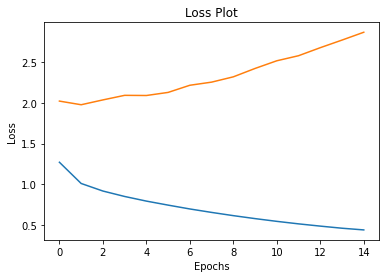

In [82]:
# Plotting the graph for train & test loss

plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [65]:
max_l = 35
features_shape = 2048
attention_features_shape = 64

In [66]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [85]:
# Function to plot attention model results

def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 20))
    temp_img = np.array(Image.open(image))
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        ax = fig.add_subplot((len_cap//3)+1 , 3, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        #ax.imshow(temp_img)
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

In [68]:
from nltk.translate.bleu_score import sentence_bleu

In [69]:
def remove_tags(text):
    text = text.replace("<start>","")
    text = text.replace("<unk>","")
    text = text.replace("<end>","")    
    return " ".join(text.split())

In [84]:
# Function to calculate the BLEU score

def calculate_bleu_score(index, real_caption,prediction_list):
    real_caption = remove_tags(real_caption)
    #print("prediction_list",prediction_list)
    pred_caption=' '.join(prediction_list[:-1])
    real_caption_words = []
    real_caption_words.append(real_caption.split())
    reference = real_caption_words
    candidate = pred_caption.split()
    score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    print(f'Real Caption {index+1}: {real_caption}')
    print(f"BELU score 1,2,3,4: {round(score1*100,2)},{round(score2*100,2)},{round(score3*100,2)},{round(score3*100,2)}\n")
    



In [71]:
def execute_test(test_image_name=None,
                 real_caption=None,
                 path_test=path_test,
                 cap_test=cap_test):
  if not test_image_name:
    rid = np.random.randint(0, len(path_test))
    
    test_image = path_test[rid]
    
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
  else:
    test_image = f'{basePath}/{test_image_name}'
  
  file_name = test_image.split("/")[-1]
  print(f"Image Name : {file_name}\n")
  
  all_captions = list(df_captions[df_captions['image'] == file_name]['caption'])
  result, attention_plot,pred_test = evaluate(test_image)
  pred_caption = ' '.join(result[:-1])
  print('Prediction Caption:', pred_caption)
  for index, caption in enumerate(all_captions):
    calculate_bleu_score(index, caption, result)

  plot_attmap(result, attention_plot, test_image)
  img = mpimg.imread(test_image)
  plt.figure(figsize=(10, 20))
  imgplot = plt.imshow(img)
  plt.show()

  return pred_caption,test_image

Image Name : 2144049642_070cf541b4.jpg

Prediction Caption: a young girl coloring pictures indoors
Real Caption 1: A girl colors with markers .
BELU score 1,2,3,4: 16.67,40.82,58.42,58.42

Real Caption 2: A little girl is carefully coloring in the pictures of a coloring book .
BELU score 1,2,3,4: 17.57,21.52,23.34,23.34

Real Caption 3: A young girl colors in a coloring book with a choice of many colors from a container .
BELU score 1,2,3,4: 9.02,4.94,7.39,7.39

Real Caption 4: Little girl coloring pictures indoors .
BELU score 1,2,3,4: 66.67,63.25,61.7,61.7

Real Caption 5: The little girl is using colored pencils to decorate a coloring book .
BELU score 1,2,3,4: 15.57,22.02,25.29,25.29



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


<Figure size 800x1600 with 0 Axes>

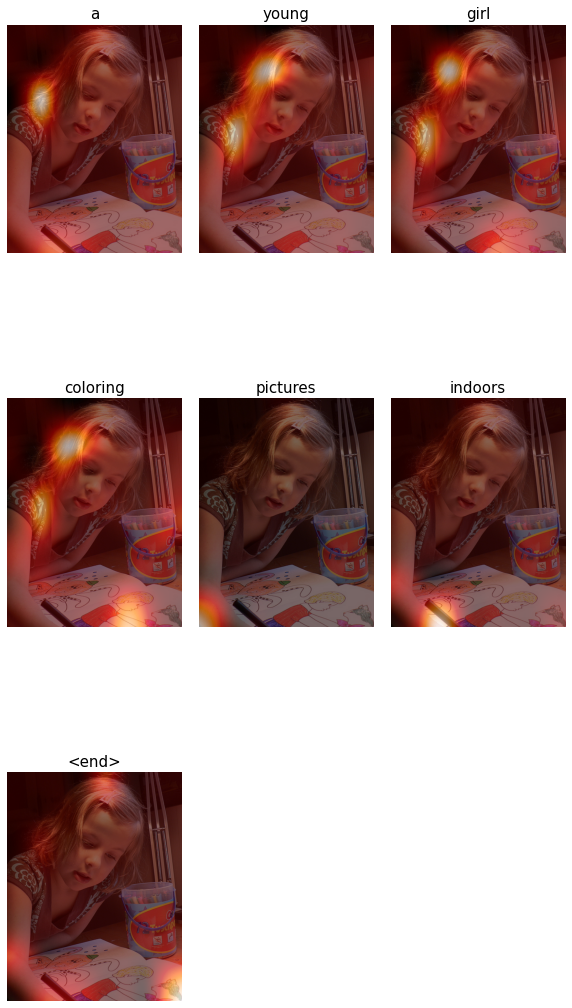

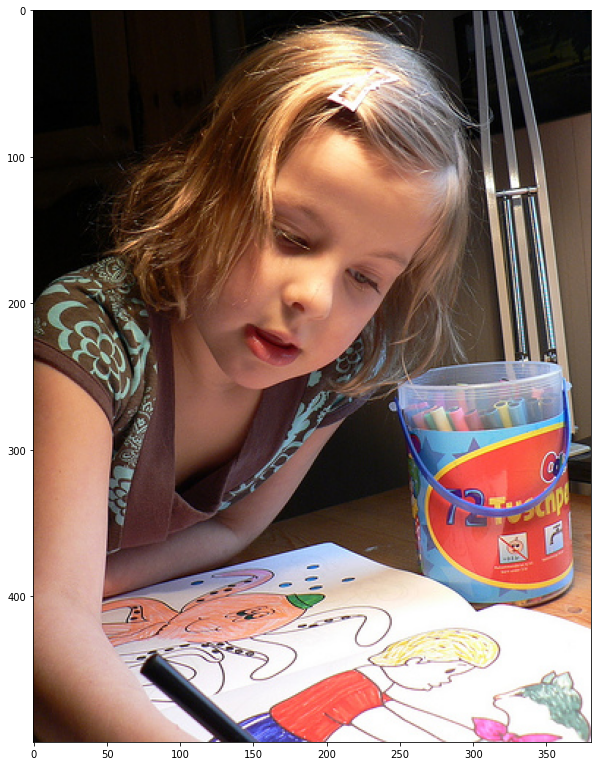

In [72]:
plt.figure(figsize=(10, 20), dpi=80)
pred_caption, image_path = execute_test()
tts = gTTS("Predicted Caption is: "+ pred_caption) 
sound_file = f'{basePath}/s.wav'
tts.save(sound_file)

Audio(sound_file, autoplay=True)

Image Name : IMG_20161231_113120.jpg

Prediction Caption: a man is petting a military tulips


<Figure size 800x1600 with 0 Axes>

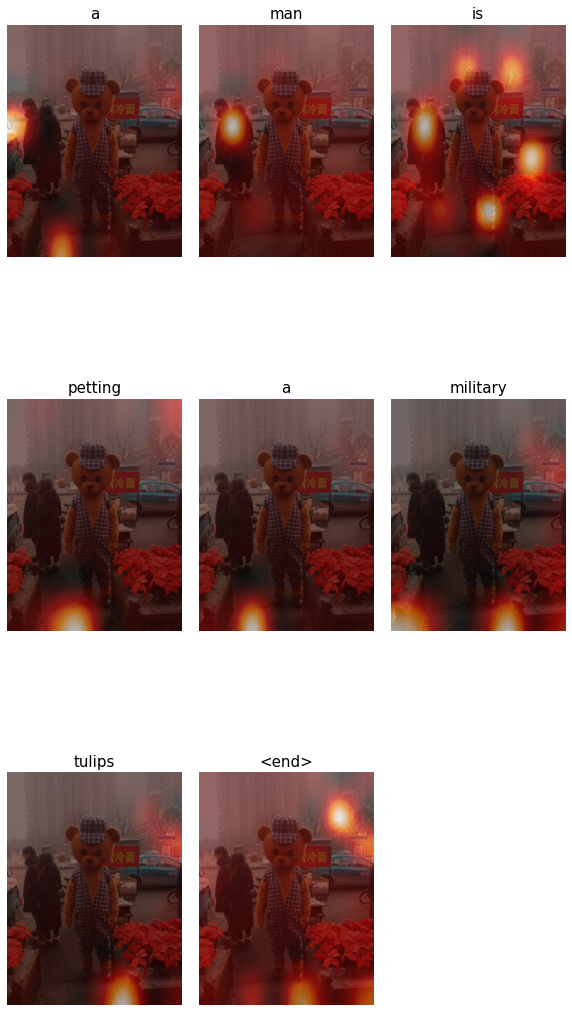

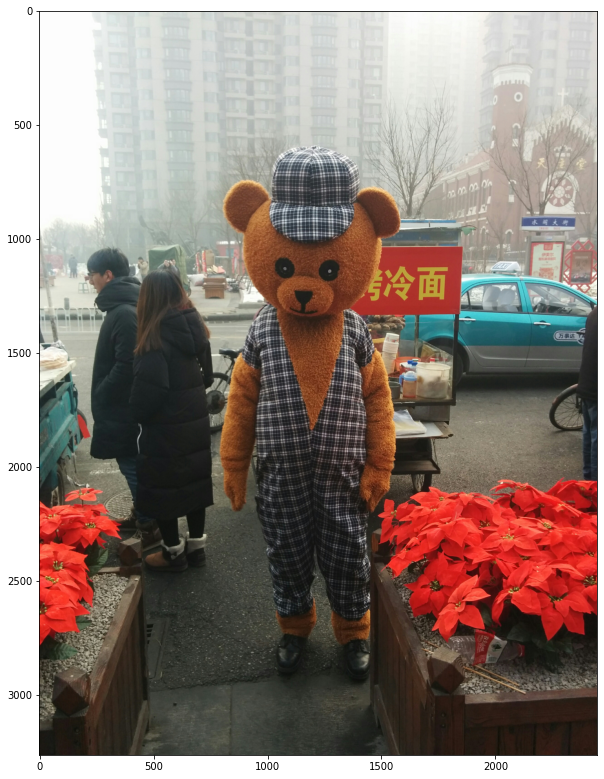

In [81]:
plt.figure(figsize=(10, 20), dpi=80)
pred_caption, image_path = execute_test(test_image_name="IMG_20161231_113120.jpg", real_caption="a Teddy is standing near the tulips")
tts = gTTS("Predicted Caption is: "+ pred_caption) 
sound_file = f'{basePath}/s.wav'
tts.save(sound_file)

Audio(sound_file, autoplay=True)

Image Name : IMG_20170121_132844.jpg

Prediction Caption: a group of people


<Figure size 800x1600 with 0 Axes>

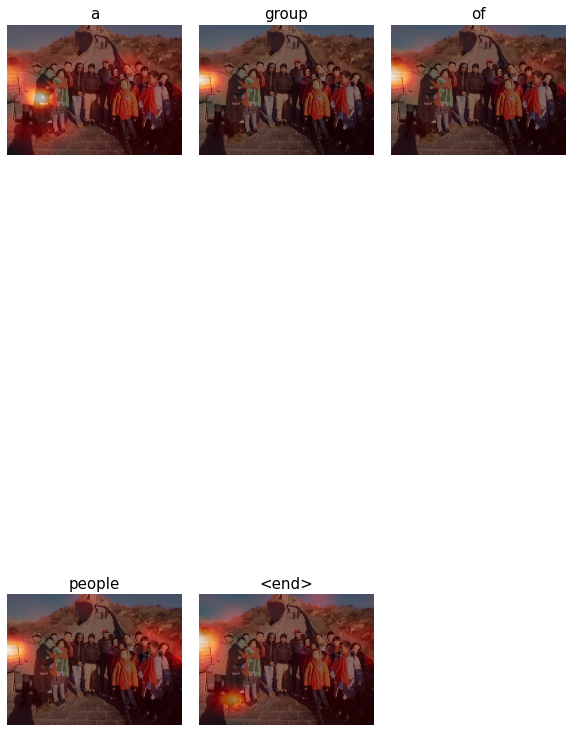

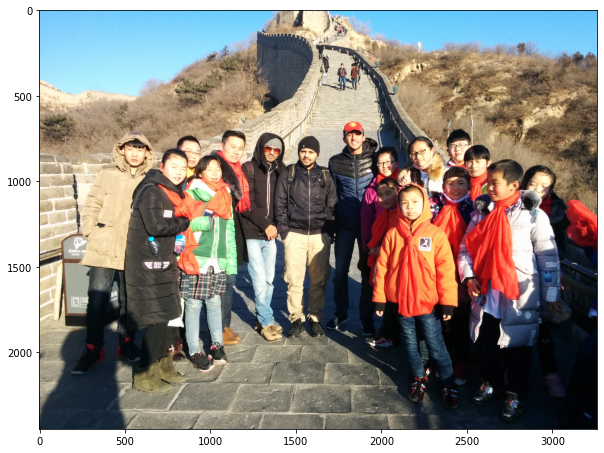

In [79]:
plt.figure(figsize=(10, 20), dpi=80)
pred_caption, image_path = execute_test(test_image_name="IMG_20170121_132844.jpg", real_caption="A group of people on a mountain")
tts = gTTS("Predicted Caption is: "+ pred_caption) 
sound_file = f'{basePath}/s.wav'
tts.save(sound_file)

Audio(sound_file, autoplay=True)

As seen above the model is able to predict the captions on the unseen data fairly well